# Два генератора точек в круге

## Условие

Даны два алгоритма генерации точек в круге

```python
def generate1():
    a = uniform(0, 1)
    b = uniform(0, 1)
    return a * cos(2 * pi * b), a * sin(2 * pi * b)
```
и
```python
def generate2():
    while True:
        x = uniform(-1, 1)
        y = uniform(-1, 1)
        if x ** 2 + y ** 2 > 1:
            continue
        return x, y
```
Случайно выбирается алгоритм, и с его помощью генерируется 1000 точек
Цель: Выявить, каким алгоритмом были сгенерированы точки

## Исследование

### Подключаем нужные библиотеки

In [1]:
from datetime import datetime as dt

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pylab as plt
from numpy import sin, cos, pi
from numpy.random import uniform
from torch.utils.tensorboard import SummaryWriter
from tqdm.contrib.itertools import product
from tqdm.notebook import trange

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Объявляем алгоритмы

Также необходимо написать функцию, которая будет генерировать тензор, состоящий из нескольких наборов по 1000 точек. Это нужно для дальнейшего обучения с использованием батчей по 2, 4, 8 и т.д наборов.

In [3]:
def generate1():
    a = uniform(0, 1)
    b = uniform(0, 1)
    return a * cos(2 * pi * b), a * sin(2 * pi * b)


def generate1_tensor(length=1000, _device=device, batch_size=1):
    return torch.Tensor([
        [generate1() for _ in range(length)]
        for _ in range(batch_size)
    ]).to(_device)

In [4]:
def generate2():
    while True:
        x = uniform(-1, 1)
        y = uniform(-1, 1)
        if x ** 2 + y ** 2 > 1:
            continue
        return x, y


def generate2_tensor(length=1000, _device=device, batch_size=1):
    return torch.Tensor([
        [generate2() for _ in range(length)]
        for _ in range(batch_size)
    ]).to(_device)

### Визуализация

Во-первых, необходимо чётко понимать различия между этими двумя алгоритмами. Для этого построим три иллюстрации.

Первая иллюстрация будет отражать распределение точек, полученных первым алгоритмом. Вторая - распределение точек, полученных вторым алгоритмом. Третья иллюстрация покажет результаты обоих алгоритмов одновременно.

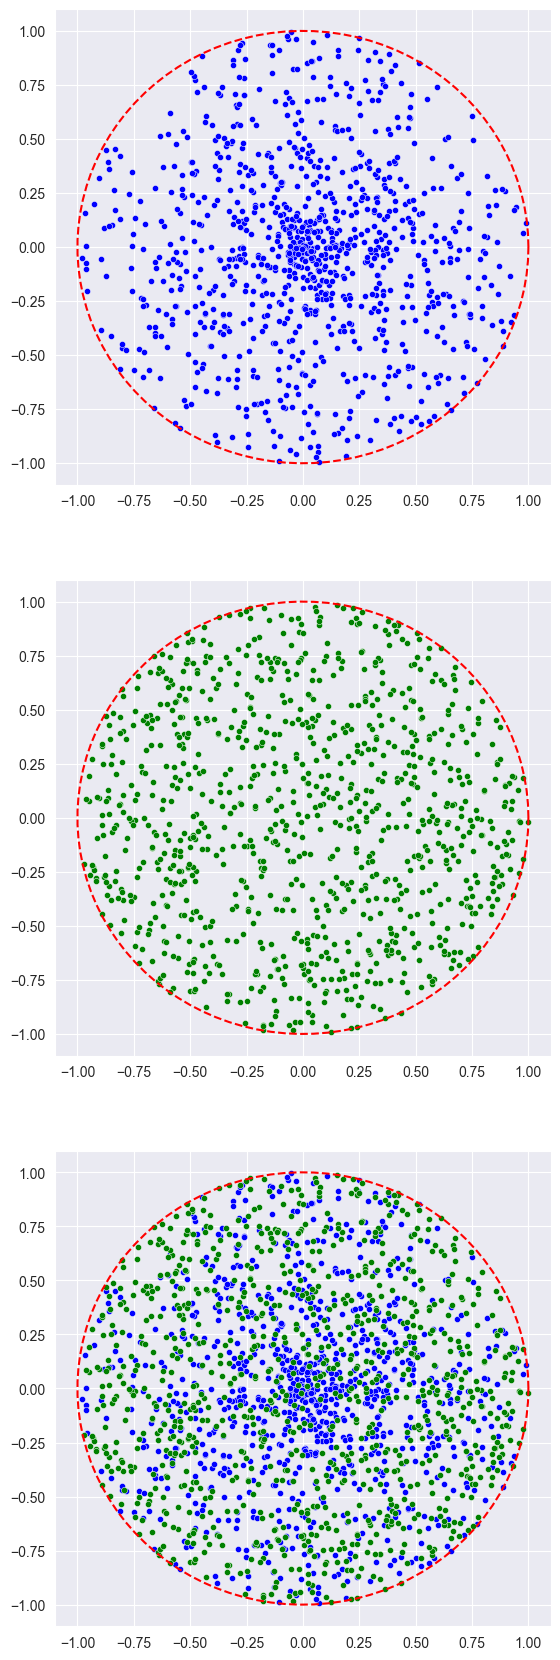

In [5]:
data1 = np.array([generate1() for _ in range(1000)])
data2 = np.array([generate2() for _ in range(1000)])
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

fig.set_figheight(21)

sns.scatterplot(x=data1[..., 0], y=data1[..., 1], ax=ax1, color="b", s=20)
sns.scatterplot(x=data2[..., 0], y=data2[..., 1], ax=ax2, color="g", s=20)

sns.scatterplot(x=data1[..., 0], y=data1[..., 1], ax=ax3, color="b", s=20)
sns.scatterplot(x=data2[..., 0], y=data2[..., 1], ax=ax3, color="g", s=20)

circle = np.array([(cos(t), sin(t)) for t in np.linspace(0, 2 * pi, 100)])
ax1.plot(circle[..., 0], circle[..., 1], "r--")
ax2.plot(circle[..., 0], circle[..., 1], "r--")
ax3.plot(circle[..., 0], circle[..., 1], "r--");

### Архитектура модели

Решим эту задачу обычным перцептроном с одним скрытым слоем. Последовательность обработки входных данных завершается применением сигмойды, что гарантирует получение ответа в промежутке $(0, 1)$. Пусть $1$ будет отвечать за первый алгоритм, а $0$ второй соответственно

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(2, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.output(x)
        x = F.sigmoid(x)
        return x

### Функция для обучения

In [7]:
def train(epochs, learning_rate, batch_size, prefix="", verbose=True):
    _model = Net().to(device)
    optimizer = torch.optim.Adam(_model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    writer = SummaryWriter(f'runs/{prefix}BS {batch_size} LR {learning_rate} TE {epochs} {dt.now().timestamp()}')

    pbar = trange(epochs) if verbose else range(epochs)

    for epoch in pbar:
        if np.random.random() < 0.5:
            x = generate1_tensor(batch_size=batch_size)
            y = torch.Tensor(
                [[1000] for _ in range(batch_size)]
            ).to(device)
        else:
            x = generate2_tensor(batch_size=batch_size)
            y = torch.Tensor(
                [[0] for _ in range(batch_size)]
            ).to(device)

        optimizer.zero_grad()
        out = _model(x).sum(1)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            length = 1000
            scores = []
            for _ in range(12):
                if np.random.random() < 0.5:
                    scores.append(int(
                        _model(generate1_tensor()).sum() > length / 2
                    ))
                else:
                    scores.append(int(
                        _model(generate2_tensor()).sum() < length / 2
                    ))

        writer.add_scalar("Accuracy", sum(scores) / len(scores), epoch)

    return _model

 ### Перебор гиперпараметров

In [8]:
ls_list = [0.1, 0.05, 0.01, 0.005]
bs_list = [1, 2, 4, 8, 16, 32]
total = len(ls_list) * len(bs_list)
ep_list = [1000]

for ep, ls, bs in product(ep_list, ls_list, bs_list):
    train(ep, ls, bs, "GS ", False)

  0%|          | 0/24 [00:00<?, ?it/s]


| Accuracy | BatchSize | LearningRate |
| -------- | --------- | ------------ |
| 0.7995   | 32        | 0.05         |
| 0.7865   | 2         | 0.1          |
| 0.7781   | 8         | 0.1          |
| 0.7632   | 4         | 0.1          |
| 0.7523   | 2         | 0.05         |
| 0.7456   | 2         | 0.005        |
| 0.7226   | 1         | 0.005        |
| 0.7172   | 16        | 0.01         |
| 0.7137   | 8         | 0.05         |
| 0.7128   | 32        | 0.01         |
| 0.6972   | 4         | 0.05         |
| 0.6860   | 1         | 0.05         |
| 0.6844   | 16        | 0.05         |
| 0.6781   | 1         | 0.1          |
| 0.6655   | 8         | 0.01         |
| 0.6624   | 4         | 0.01         |
| 0.6459   | 8         | 0.005        |
| 0.6451   | 2         | 0.01         |
| 0.6369   | 1         | 0.01         |
| 0.6145   | 32        | 0.005        |
| 0.5946   | 4         | 0.005        |
| 0.5567   | 16        | 0.005        |
| 0.5015   | 16        | 0.1          |
| 0.5006   | 32        | 0.1          |


### Обучение финальной модели

In [9]:
final_model = train(10_000, 0.05, 32, "Fin ", True)

### Сохранение параметров модели

In [10]:
final_model.state_dict()

## Решение

In [11]:
# Библиотеки
from collections import OrderedDict
from torch import Tensor as tensor
import torch.nn as nn
import torch.nn.functional as F


# Архитектура
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(2, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.output(x)
        x = F.sigmoid(x)
        return x


# Инициализация и загрузка весов
predictor = Net()
predictor.load_state_dict(
    OrderedDict(
        [
            (
                'input.weight',
                tensor([[0.0752, -0.1233],
                        [-0.2479, 0.1645],
                        [-0.1765, 0.1214],
                        [-0.3667, -0.3619],
                        [-0.3010, 0.3529],
                        [-0.0108, -7.8048],
                        [0.0358, -0.3973],
                        [-0.0586, -0.0203],
                        [-8.2604, -3.5160],
                        [5.9318, 6.8740],
                        [0.2309, -0.2412],
                        [0.0924, 0.1593],
                        [8.2348, -2.9564],
                        [0.2357, 0.0211],
                        [-7.3725, 4.3372],
                        [-2.8912, 7.8993]])
            ),
            (
                'input.bias',
                tensor([-0.1656, -0.8814, 
                        -0.3796, -0.7413, 
                        -0.7010, -3.6093,
                        -0.6750, -0.3006,
                        -4.1550, -4.2129, 
                        -0.4278, -0.2497, 
                        -4.1007, -0.5201, 
                        -4.3386, -4.0382])
            ),
            (
                'output.weight',
                tensor([[0.1248, -0.1731, 
                         0.0716, 0.0511, 
                         0.0754, -7.2949, 
                         -0.1968, 0.0412,
                         -5.9629, -5.9001, 
                         -0.0713, 0.1077, 
                         -6.9395, -0.1603, 
                         -5.3420, -6.0077]])
            ),
            (
                'output.bias',
                tensor([8.4500])
            )
        ]
    )
)

# Цикл с решением
for _ in range(100):
    data = list(map(float, input().split()))
    prepared = [[0, 0] for _ in range(1000)]

    for i in range(0, 2000, 2):
        prepared[i // 2][0] = data[i]
        prepared[i // 2][1] = data[i + 1]

    tensor_data = tensor(prepared)
    if predictor(tensor_data).sum() > 500:
        print(1)
    else:
        print(2)

<All keys matched successfully>